## Import Libraries


In [16]:
import numpy as np 
import pandas as pd 
import os

import datetime as dt
from datetime import datetime

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import numpy as np

from sklearn.preprocessing import MinMaxScaler

### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from keras.layers import Dropout

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
import pickle
import tabulate

## Loading Stock Data

In [17]:
data = './data/AMZN.csv'

In [18]:
df = pd.read_csv(data)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-01-03,175.889999,179.479996,175.550003,179.029999,179.029999,5110800
1,2012-01-04,179.210007,180.500000,176.070007,177.509995,177.509995,4205200
2,2012-01-05,175.940002,178.250000,174.050003,177.610001,177.610001,3809100
3,2012-01-06,178.070007,184.649994,177.500000,182.610001,182.610001,7008400
4,2012-01-09,182.759995,184.369995,177.000000,178.559998,178.559998,5056900


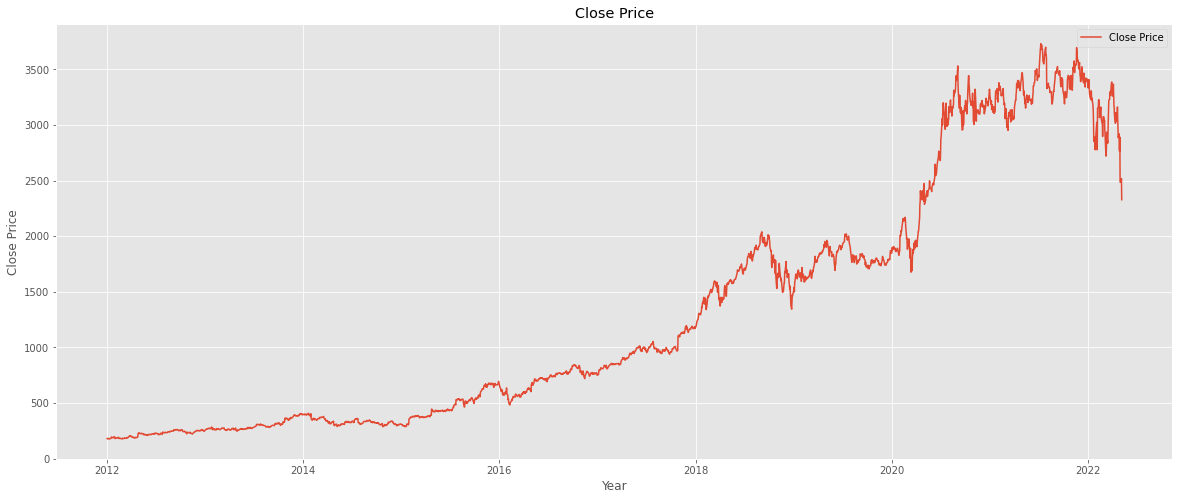

In [19]:
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']
plt.figure(figsize=(20,8))
plt.plot(df['Close'], label='Close Price')
plt.xlabel('Year')
plt.ylabel('Close Price') 
plt.title('Close Price')
plt.legend() 

In [20]:
features = ["Date", "Close"]
all_data = df[features]
all_data.index = all_data.Date
all_data.drop('Date', axis=1, inplace=True)

/home/codevardhan/.env-list/mach-env/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [21]:
print(all_data.shape)
all_data.head()


(2603, 1)


,Close
Date,
2012-01-03,179.029999
2012-01-04,177.509995
2012-01-05,177.610001
2012-01-06,182.610001
2012-01-09,178.559998


## Loading sentiment data and augmenting training data

In [ ]:
tokenizer = Tokenizer()

with open("sentiment_analysis_models/tokenizer.pkl", "rb") as handle:
    tokenizer = pickle.load(handle)

In [ ]:
# function that uses the model to predict score
def get_score(text):
    model = load_model("sentiment_analysis_models/model.h5")
    # Tokenize text
    tokenized_text = pad_sequences(tokenizer.texts_to_sequences([str(text)]), maxlen=300)
    # Predict
    score = model.predict([tokenized_text])[0]
    # Decode sentiment
    return float(score)
    
print(get_score("idk what to do"))

In [ ]:
sec_data=pd.concat([pd.read_csv('output/sec_8k.csv'), pd.read_csv('output/sec_10k.csv')])
sec_data.head()

In [ ]:
sec_data["sentiment"] = sec_data["data"].apply(lambda x: get_score(x))
sec_data.head()

In [ ]:
# rescaling the sentiment scores to be between -1 and 1
def rescale(val):
    o1 = 0
    o2 = 1
    n1 = -1
    n2 = 1

    val = ( (val - o1) / (o2 - o1) ) * (n2 - n1) + n1
    return val

sec_data["sentiment"]=sec_data["sentiment"].apply(lambda x: rescale(x))
sec_data.head()


In [ ]:
sec_data.to_csv('output/sec_sentiment_data.csv', index=False)

In [22]:
sec_data = pd.read_csv('output/sec_sentiment_data.csv')
sec_data.head()

,dates,data,sentiment
0,2022-04-28,k amzn htm k amzn of contentsunited statessecu...,-0.061694
1,2022-04-14,k htm form k false inc usd xbrli shares usd xb...,0.379136
2,2022-04-13,k htm k k false united states securities and e...,0.273134
3,2022-03-09,k amzn htm k amzn of contentsunited statessecu...,0.374390
4,2022-02-03,k amzn htm k amzn of contentsunited statessecu...,-0.430636


In [23]:
df_new = pd.DataFrame(columns=['Date', 'Close', 'Sentiment'])

df = pd.read_csv('./data/AMZN.csv')

for i, row in df.iterrows():
    sentiment = 0
    for idx, row2 in sec_data.iterrows():
        if row['Date'] == row2['dates']:
            sentiment = row2['sentiment']
    
    df_new.loc[i] = [row['Date'], row['Close'], sentiment]

In [24]:
df_new.head()

,Date,Close,Sentiment
0,2012-01-03,179.029999,0
1,2012-01-04,177.509995,0
2,2012-01-05,177.610001,0
3,2012-01-06,182.610001,0
4,2012-01-09,178.559998,0


In [25]:
df_new["Sentiment"].unique()

array([0, -0.5625367164611816, 0.4611152410507202, -0.0324553847312927,
       -0.6398483514785767, -0.1048037409782409, -0.3416502475738525,
       -0.0085186958312988, -0.7438042759895325, -0.5424008369445801,
       0.242497444152832, 0.199964165687561, 0.5491327047348022,
       -0.1048862338066101, -0.7401959896087646, -0.5498631000518799,
       0.3956751823425293, -0.0252444148063659, 0.580223560333252,
       -0.2547135949134826, 0.1335667371749878, 0.6514997482299805,
       0.0797326564788818, 0.6702210903167725, 0.4344052076339721,
       -0.3402508497238159, -0.5089600086212158, -0.7306082844734192,
       -0.5564051866531372, -0.5042034387588501, 0.363162636756897,
       0.6332573890686035, -0.2069723010063171, -0.2682939767837524,
       -0.7156701683998108, -0.5281744599342346, -0.6203857064247131,
       0.1168383359909057, 0.4124402999877929, -0.2248092293739318,
       0.5919485092163086, -0.2069534063339233, -0.1633265018463134,
       -0.2688777446746826, -0.710705

In [26]:
all_data['sentiment'] = df_new['Sentiment'].values
sentiments = df_new['Sentiment'].values
all_data.head()

,Close,sentiment
Date,,
2012-01-03,179.029999,0
2012-01-04,177.509995,0
2012-01-05,177.610001,0
2012-01-06,182.610001,0
2012-01-09,178.559998,0


In [27]:
close_data = all_data.drop('sentiment', axis=1)

## Pre-processing Stock Data

In [28]:
dataset = close_data.values
train = dataset[0:2000, :]
valid = dataset[2000:, :]
# print(dataset)

In [29]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)


In [30]:
for i in range(0, len(train)-90):
    scaled_data[i, 0] += sentiments[i]*0.1

In [31]:
x_train, y_train = [], []
for i in range(90,len(train)):
    arr = scaled_data[i-90:i,0]
    np.append(arr, sentiments[i])
    x_train.append(arr)
    y_train.append(scaled_data[i,0])

x_train, y_train = np.array(x_train), np.array(y_train)

In [32]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train

array([[[8.71895235e-04],
        [4.44385016e-04],
        [4.72512302e-04],
        ...,
        [1.34918498e-02],
        [1.32330948e-02],
        [1.42765562e-02]],

       [[4.44385016e-04],
        [4.72512302e-04],
        [1.87879222e-03],
        ...,
        [1.32330948e-02],
        [1.42765562e-02],
        [1.45549971e-02]],

       [[4.72512302e-04],
        [1.87879222e-03],
        [7.39704642e-04],
        ...,
        [1.42765562e-02],
        [1.45549971e-02],
        [1.32190312e-02]],

       ...,

       [[4.63315793e-01],
        [4.46972012e-01],
        [4.53356509e-01],
        ...,
        [4.40039045e-01],
        [4.43166610e-01],
        [4.42578795e-01]],

       [[4.46972012e-01],
        [4.53356509e-01],
        [4.54923124e-01],
        ...,
        [4.43166610e-01],
        [4.42578795e-01],
        [4.39681844e-01]],

       [[4.53356509e-01],
        [4.54923124e-01],
        [4.66029920e-01],
        ...,
        [4.42578795e-01],
        [4.3968

In [33]:
inputs = close_data[len(close_data) - len(valid)-90:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)
sentiments_new = sentiments[len(close_data) - len(valid)-90:]

for i in range(0, inputs.shape[0]-90):
    inputs[i] += sentiments_new[i]*0.1

In [34]:

X_test = []
for i in range(90,inputs.shape[0]):
    arr = inputs[i-90:i,0]
    np.append(arr, sentiments_new[i])
    X_test.append(arr)
X_test = np.array(X_test)

## Making the model

In [35]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(rate = 0.3))

model.add(LSTM(units=50, return_sequences = True))
model.add(Dropout(rate = 0.3))

model.add(LSTM(units=50, return_sequences = True))
model.add(Dropout(rate = 0.3))

model.add(LSTM(units=50, return_sequences = False))
model.add(Dropout(rate = 0.3))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
#we use standard adam's optimizer

2022-05-08 16:18:23.964662: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 90, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 90, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 90, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 90, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 90, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 90, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

## Training the model

In [37]:
model.fit(x_train, y_train, epochs=100, batch_size=128, verbose=1)

Epoch 1/100
15/15 [==============================] - 9s 202ms/step - loss: 0.0131
Epoch 2/100
15/15 [==============================] - 3s 197ms/step - loss: 0.0026
Epoch 3/100
15/15 [==============================] - 3s 192ms/step - loss: 0.0016
Epoch 4/100
15/15 [==============================] - 3s 170ms/step - loss: 0.0014
Epoch 5/100
15/15 [==============================] - 3s 171ms/step - loss: 0.0013
Epoch 6/100
15/15 [==============================] - 2s 166ms/step - loss: 0.0012
Epoch 7/100
15/15 [==============================] - 3s 169ms/step - loss: 0.0012
Epoch 8/100
15/15 [==============================] - 3s 170ms/step - loss: 0.0012
Epoch 9/100
15/15 [==============================] - 3s 168ms/step - loss: 0.0011
Epoch 10/100
15/15 [==============================] - 2s 165ms/step - loss: 0.0010
Epoch 11/100
15/15 [==============================] - 2s 165ms/step - loss: 0.0012
Epoch 12/100
15/15 [==============================] - 2s 164ms/step - loss: 9.6042e-04
Epoch 13/

In [38]:
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
preds = model.predict(X_test)
preds = scaler.inverse_transform(preds)

In [39]:
print(preds.shape)

(603, 1)


In [40]:
print(valid.shape)

(603, 1)


In [41]:
print(valid[-1],preds[-1])

[2328.139893] [2677.3877]


## Results

In [42]:
rms=np.sqrt(np.mean(np.power((valid-preds),2)))
rms

291.6632873159379

/tmp/ipykernel_7852/3774970882.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = preds


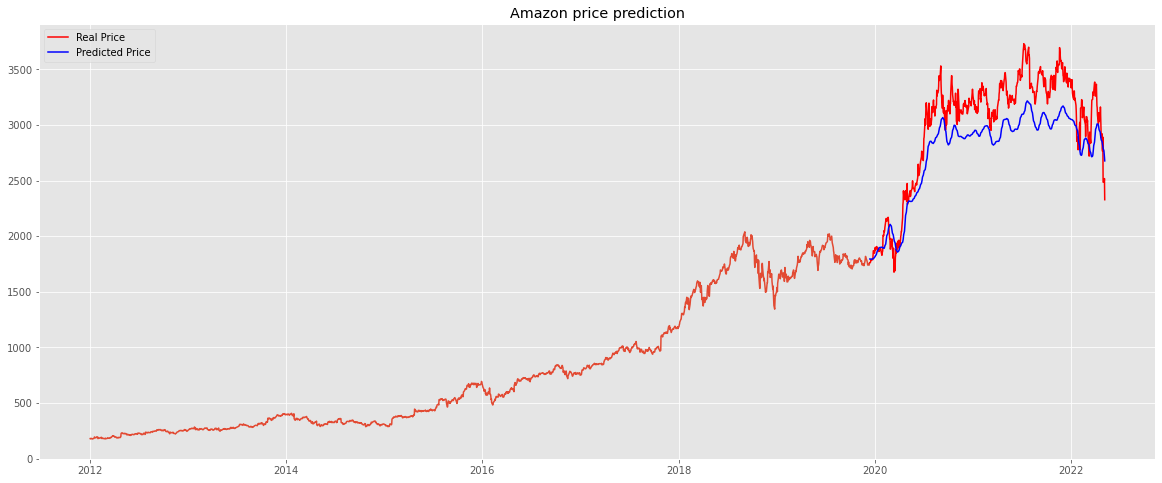

In [43]:
train = all_data[0:2000]
valid = all_data[2000:]
valid['Predictions'] = preds
plt.figure(figsize=(20,8))
plt.plot(train['Close'])
plt.plot(valid['Close'], color = 'red', label = 'Real Price')
plt.plot(valid['Predictions'], color = 'blue', label = 'Predicted Price')
plt.title('Amazon price prediction')
plt.legend()
plt.show()

valid.to_csv('output/preds_sent.csv')

In [52]:
valid = pd.read_csv('output/preds_sent.csv')
valid_no_sent = pd.read_csv('output/preds_no_sent.csv')

l1 = ['With Sentiment']
l2 = ['Without Sentiment']
l3 = ['Actual Value']
l4 = ['Sentiment Value']

for i, row in valid.iterrows():
    if row['sentiment'] != 0.0 and row['sentiment']>0:
            l1.append(row['Predictions'])
            l2.append(valid_no_sent.loc[i]['Predictions'])
            l3.append(row['Close'])
            l4.append(row['sentiment'])

data = [l1, l2, l3, l4]
table = tabulate.tabulate(data, tablefmt='html')
table

With Sentiment,1893.98,1989.04,2360.12,2485.64,2912.04,3066.33,2945.73,3031.6,2942.6,3097.23,3112.18,2801.92,2977.14,2957.62
Without Sentiment,1848.7,1943.28,2311.82,2436.82,2874.03,3024.87,2904.44,3003.68,2907.73,3063.82,3078.99,2766.26,2943.7,2925.7
Actual Value,2008.72,2408.19,2442.37,2764.41,3284.72,3268.61,3379.09,3151.94,3223.07,3510.98,3355.73,2785.58,3110.82,3034.13
Sentiment Value,0.520708,0.379153,0.590209,0.517354,0.281803,0.189591,0.379112,0.276488,0.636369,0.163389,0.146209,0.37439,0.273134,0.379136


In [46]:
for i, row in valid.iterrows():
    print(row['Date'])

2019-12-13
2019-12-16
2019-12-17
2019-12-18
2019-12-19
2019-12-20
2019-12-23
2019-12-24
2019-12-26
2019-12-27
2019-12-30
2019-12-31
2020-01-02
2020-01-03
2020-01-06
2020-01-07
2020-01-08
2020-01-09
2020-01-10
2020-01-13
2020-01-14
2020-01-15
2020-01-16
2020-01-17
2020-01-21
2020-01-22
2020-01-23
2020-01-24
2020-01-27
2020-01-28
2020-01-29
2020-01-30
2020-01-31
2020-02-03
2020-02-04
2020-02-05
2020-02-06
2020-02-07
2020-02-10
2020-02-11
2020-02-12
2020-02-13
2020-02-14
2020-02-18
2020-02-19
2020-02-20
2020-02-21
2020-02-24
2020-02-25
2020-02-26
2020-02-27
2020-02-28
2020-03-02
2020-03-03
2020-03-04
2020-03-05
2020-03-06
2020-03-09
2020-03-10
2020-03-11
2020-03-12
2020-03-13
2020-03-16
2020-03-17
2020-03-18
2020-03-19
2020-03-20
2020-03-23
2020-03-24
2020-03-25
2020-03-26
2020-03-27
2020-03-30
2020-03-31
2020-04-01
2020-04-02
2020-04-03
2020-04-06
2020-04-07
2020-04-08
2020-04-09
2020-04-13
2020-04-14
2020-04-15
2020-04-16
2020-04-17
2020-04-20
2020-04-21
2020-04-22
2020-04-23
2020-04-24

In [ ]:
from keras.models import load_model
model.save('AMZN.h5')  # creates a HDF5 file 